<a href="https://colab.research.google.com/github/alexandr-khvatov/text_classification/blob/main/model/bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!pip install transformers --quiet
!pip install wget --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 78.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 77.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 20.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [11]:
import torch
from torch.utils.data import Dataset
class BertDataset(Dataset):

  def __init__(self, texts, targets, tokenizer, max_len=512):
    self.texts = texts
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = str(self.texts[idx])
    target = self.targets[idx]

    encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )

    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [23]:
from tqdm import tqdm
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report


class BertClassifier:

    def __init__(self, path, n_classes=2):
        self.path = path
        self.model = BertForSequenceClassification.from_pretrained(path)
        self.tokenizer = BertTokenizer.from_pretrained(path)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.max_len = 512
        self.out_features = self.model.bert.encoder.layer[1].output.dense.out_features
        self.model.classifier = torch.nn.Linear(self.out_features, n_classes)
        self.model.to(self.device)

    
    def preparation(self, X_train, y_train, epochs):
        # create datasets
        self.train_set = BertDataset(X_train, y_train, self.tokenizer)
        # create data loaders
        self.train_loader = DataLoader(self.train_set, batch_size=2, shuffle=True)
        # helpers initialization
        self.optimizer = AdamW(
            self.model.parameters(),
            lr=2e-5,
            weight_decay=0.005,
            correct_bias=True
            )
        self.scheduler = get_linear_schedule_with_warmup(
                self.optimizer,
                num_warmup_steps=500,
                num_training_steps=len(self.train_loader) * epochs
            )
        self.loss_fn = torch.nn.CrossEntropyLoss().to(self.device)


    def fit(self):
        self.model = self.model.train()
        losses = []
        correct_predictions = 0

        for data in tqdm(self.train_loader):
            input_ids = data["input_ids"].to(self.device)
            attention_mask = data["attention_mask"].to(self.device)
            targets = data["targets"].to(self.device)

            outputs = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask
                )

            preds = torch.argmax(outputs.logits, dim=1)
            loss = self.loss_fn(outputs.logits, targets)

            correct_predictions += torch.sum(preds == targets)

            losses.append(loss.item())
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            self.scheduler.step()
            self.optimizer.zero_grad()

        train_acc = correct_predictions.double() / len(self.train_set)
        train_loss = np.mean(losses)
        return train_acc, train_loss
    

    def train(self, X_train, y_train, X_valid, y_valid, X_test, y_test, epochs=5):
        print('*' * 10)
        print(f'Model: {self.path}')
        self.preparation(X_train, y_train, epochs)
        for epoch in range(epochs):
            print(f'Epoch {epoch + 1}/{epochs}')
            train_acc, train_loss = self.fit()
            print(f'Train loss {train_loss} accuracy {train_acc}')
            predictions_valid = [self.predict(x) for x in X_valid]
            precision, recall, f1score = precision_recall_fscore_support(y_valid, predictions_valid, average='macro')[:3]
            print('Valid:')
            print('Accuracy:', score_to_percent(accuracy_score(y_valid, predictions_valid)))
            print("Recall:", score_to_percent(recall_score(y_valid, predictions_valid)))
            print(f'precision: {precision}, recall: {recall}, f1score: {f1score}')
            predictions_test = [self.predict(x) for x in X_test]
            precision, recall, f1score = precision_recall_fscore_support(y_test, predictions_test, average='macro')[:3]
            print('Test:')
            print('Accuracy:', score_to_percent(accuracy_score(y_test, predictions_test)))
            print("Recall:", score_to_percent(recall_score(y_test, predictions_test)))
            print(f'precision: {precision}, recall: {recall}, f1score: {f1score}')
            print('*'*21)
            print(classification_report(y_test, predictions_test))
            print('Accuracy:', score_to_percent(accuracy_score(y_test, predictions_test)))
            print("Recall:", score_to_percent(recall_score(y_test, predictions_test)))
            print("Precision:",score_to_percent(precision_score(y_test, predictions_test)))
            print("F1-score:", score_to_percent(f1_score(y_test, predictions_test)), '\n')
            print('*' * 21)
            
            plot_cm(y_test,predictions_test)
        print('*' * 10)
    
    def predict(self, text):
        self.model = self.model.eval()
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        out = {
              'text': text,
              'input_ids': encoding['input_ids'].flatten(),
              'attention_mask': encoding['attention_mask'].flatten()
          }
        
        input_ids = out["input_ids"].to(self.device)
        attention_mask = out["attention_mask"].to(self.device)
        
        outputs = self.model(
            input_ids=input_ids.unsqueeze(0),
            attention_mask=attention_mask.unsqueeze(0)
        )
        
        prediction = torch.argmax(outputs.logits, dim=1).cpu().numpy()[0]

        return prediction

In [24]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def score_to_percent(score):
    return str(round(score * 100, 2)) + ' %'

def plot_cm(labels, predictions, p=0.5):
  print(type(labels)) 
  print(type(predictions))   
  cm = confusion_matrix(labels, predictions)
  plt.rcParams.update({'font.size': 22})
  plt.figure(figsize=(7,7))
  sns.heatmap(cm, annot=True, fmt="d",cmap='PuBu')
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
#   print("Accuracy:", score_to_percent(accuracy_score(y_test, pred)))
#   print("Recall:", score_to_percent(recall_score(y_test, pred)))
#   print("Precision:",score_to_percent(precision_score(y_test, pred)))
#   print("F1-score:", score_to_percent(f1_score(y_test, pred)), '\n')  
  print('True Negatives: ', cm[0][0])
  print('False Positives: ', cm[0][1])
  print('False Negatives: ', cm[1][0])
  print('True Positives: ', cm[1][1])

In [25]:
import wget
import os
url = 'https://raw.githubusercontent.com/alexandr-khvatov/text_classification/main/data/data_cleaned_RU.csv'

PATH_CLEANED_DATASET = 'data_cleaned_RU.csv'
if not os.path.exists(PATH_CLEANED_DATASET):
    wget.download(url)

In [32]:
import pandas as pd
import sklearn
from google.colab import drive
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split

df = pd.read_csv(PATH_CLEANED_DATASET)
df=df.astype({'toxic': 'int64'})
sentences = df.comment.values
labels = df.toxic.values

X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.12, random_state=42) # 0.25 x 0.8 = 0.2


Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not i

**********
Model: cointegrated/rubert-tiny
Epoch 1/7


100%|██████████| 5707/5707 [02:23<00:00, 39.65it/s]


Train loss 0.5530445769162229 accuracy 0.8308069745027601
Valid:
Accuracy: 88.7 %
Recall: 84.36 %
precision: 0.8712020905923346, recall: 0.8760976362035072, f1score: 0.8735548172757475
Test:
Accuracy: 88.77 %
Recall: 82.38 %
precision: 0.8728534563224071, recall: 0.8712098849654852, f1score: 0.872022211654983
*********************
              precision    recall  f1-score   support

           0       0.91      0.92      0.92       971
           1       0.83      0.82      0.83       471

    accuracy                           0.89      1442
   macro avg       0.87      0.87      0.87      1442
weighted avg       0.89      0.89      0.89      1442

Accuracy: 88.77 %
Recall: 82.38 %
Precision: 83.08 %
F1-score: 82.73 % 

*********************
<class 'numpy.ndarray'>
<class 'list'>
True Negatives:  892
False Positives:  79
False Negatives:  83
True Positives:  388
Epoch 2/7


100%|██████████| 5707/5707 [02:25<00:00, 39.35it/s]


Train loss 0.4269112426265837 accuracy 0.900990099009901
Valid:
Accuracy: 89.53 %
Recall: 83.01 %
precision: 0.8839174792003914, recall: 0.8789655185227851, f1score: 0.8813557895799761
Test:
Accuracy: 89.04 %
Recall: 78.98 %
precision: 0.8825931000296048, recall: 0.8645234081352864, f1score: 0.8725581228842286
*********************
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       971
           1       0.86      0.79      0.82       471

    accuracy                           0.89      1442
   macro avg       0.88      0.86      0.87      1442
weighted avg       0.89      0.89      0.89      1442

Accuracy: 89.04 %
Recall: 78.98 %
Precision: 86.31 %
F1-score: 82.48 % 

*********************
<class 'numpy.ndarray'>
<class 'list'>
True Negatives:  912
False Positives:  59
False Negatives:  99
True Positives:  372
Epoch 3/7


100%|██████████| 5707/5707 [02:25<00:00, 39.28it/s]


Train loss 0.3420420353278094 accuracy 0.9246473319898362
Valid:
Accuracy: 90.43 %
Recall: 84.75 %
precision: 0.8935468813269545, recall: 0.8900589369790525, f1score: 0.8917614443564721
Test:
Accuracy: 89.81 %
Recall: 81.32 %
precision: 0.8892579185520362, recall: 0.8762006905132057, f1score: 0.8822054511112112
*********************
              precision    recall  f1-score   support

           0       0.91      0.94      0.93       971
           1       0.87      0.81      0.84       471

    accuracy                           0.90      1442
   macro avg       0.89      0.88      0.88      1442
weighted avg       0.90      0.90      0.90      1442

Accuracy: 89.81 %
Recall: 81.32 %
Precision: 86.65 %
F1-score: 83.9 % 

*********************
<class 'numpy.ndarray'>
<class 'list'>
True Negatives:  912
False Positives:  59
False Negatives:  88
True Positives:  383
Epoch 4/7


100%|██████████| 5707/5707 [02:24<00:00, 39.40it/s]


Train loss 0.2843005056578557 accuracy 0.9395426268290547
Valid:
Accuracy: 89.72 %
Recall: 85.71 %
precision: 0.8828406606529368, recall: 0.8871854805444795, f1score: 0.8849419536959718
Test:
Accuracy: 90.08 %
Recall: 86.2 %
precision: 0.8854966441795062, recall: 0.8908330982789647, f1score: 0.8880650528309978
*********************
              precision    recall  f1-score   support

           0       0.93      0.92      0.93       971
           1       0.84      0.86      0.85       471

    accuracy                           0.90      1442
   macro avg       0.89      0.89      0.89      1442
weighted avg       0.90      0.90      0.90      1442

Accuracy: 90.08 %
Recall: 86.2 %
Precision: 83.88 %
F1-score: 85.03 % 

*********************
<class 'numpy.ndarray'>
<class 'list'>
True Negatives:  893
False Positives:  78
False Negatives:  65
True Positives:  406
Epoch 5/7


100%|██████████| 5707/5707 [02:24<00:00, 39.41it/s]


Train loss 0.23037080343946661 accuracy 0.9540874441426445
Valid:
Accuracy: 90.37 %
Recall: 86.29 %
precision: 0.8904723532470598, recall: 0.8934498571168445, f1score: 0.8919290354822589
Test:
Accuracy: 90.01 %
Recall: 84.71 %
precision: 0.8864916987543212, recall: 0.8864916987543212, f1score: 0.8864916987543212
*********************
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       971
           1       0.85      0.85      0.85       471

    accuracy                           0.90      1442
   macro avg       0.89      0.89      0.89      1442
weighted avg       0.90      0.90      0.90      1442

Accuracy: 90.01 %
Recall: 84.71 %
Precision: 84.71 %
F1-score: 84.71 % 

*********************
<class 'numpy.ndarray'>
<class 'list'>
True Negatives:  899
False Positives:  72
False Negatives:  72
True Positives:  399
Epoch 6/7


100%|██████████| 5707/5707 [02:24<00:00, 39.49it/s]


Train loss 0.1939129236099707 accuracy 0.9598703233155175
Valid:
Accuracy: 90.24 %
Recall: 87.64 %
precision: 0.8872920945958228, recall: 0.8958755262893858, f1score: 0.8913009130826184
Test:
Accuracy: 90.01 %
Recall: 86.2 %
precision: 0.8845964084499456, recall: 0.8903181652202623, f1score: 0.8873417941283703
*********************
              precision    recall  f1-score   support

           0       0.93      0.92      0.93       971
           1       0.84      0.86      0.85       471

    accuracy                           0.90      1442
   macro avg       0.88      0.89      0.89      1442
weighted avg       0.90      0.90      0.90      1442

Accuracy: 90.01 %
Recall: 86.2 %
Precision: 83.71 %
F1-score: 84.94 % 

*********************
<class 'numpy.ndarray'>
<class 'list'>
True Negatives:  892
False Positives:  79
False Negatives:  65
True Positives:  406
Epoch 7/7


100%|██████████| 5707/5707 [02:24<00:00, 39.46it/s]


Train loss 0.16060775693035242 accuracy 0.9686322614562342
Valid:
Accuracy: 90.24 %
Recall: 85.91 %
precision: 0.8892843419078797, recall: 0.8915193551863426, f1score: 0.8903838030517492
Test:
Accuracy: 90.08 %
Recall: 85.14 %
precision: 0.8868387557973288, recall: 0.8880999079461496, f1score: 0.887463946669723
*********************
              precision    recall  f1-score   support

           0       0.93      0.92      0.93       971
           1       0.85      0.85      0.85       471

    accuracy                           0.90      1442
   macro avg       0.89      0.89      0.89      1442
weighted avg       0.90      0.90      0.90      1442

Accuracy: 90.08 %
Recall: 85.14 %
Precision: 84.6 %
F1-score: 84.87 % 

*********************
<class 'numpy.ndarray'>
<class 'list'>
True Negatives:  898
False Positives:  73
False Negatives:  70
True Positives:  401
**********


('./trainer/tokenizer_config.json',
 './trainer/special_tokens_map.json',
 './trainer/vocab.txt',
 './trainer/added_tokens.json')

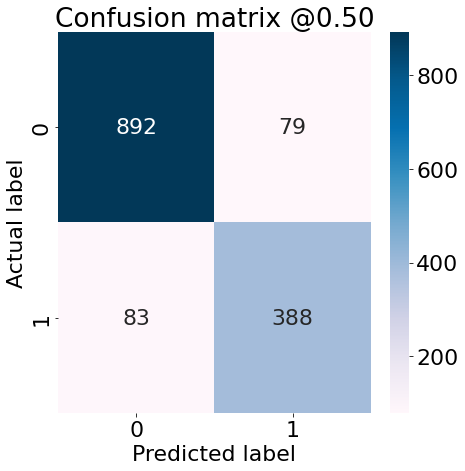

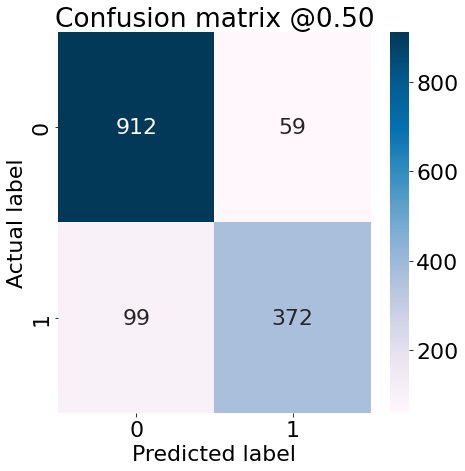

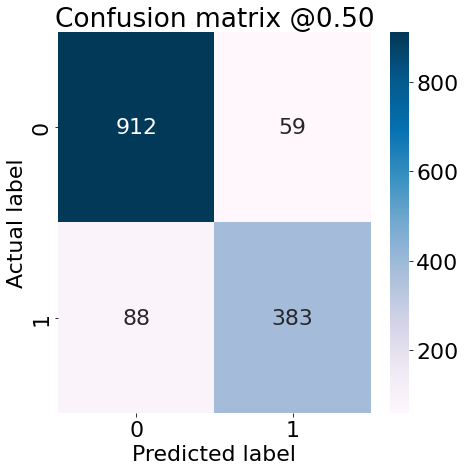

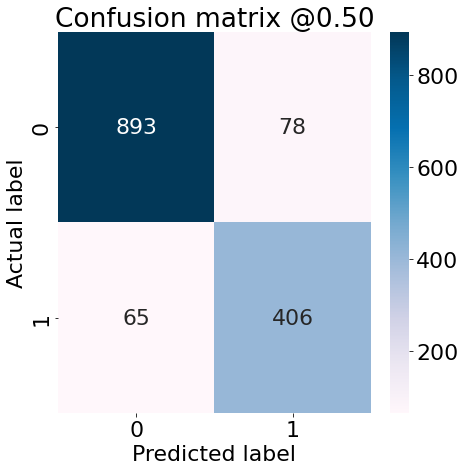

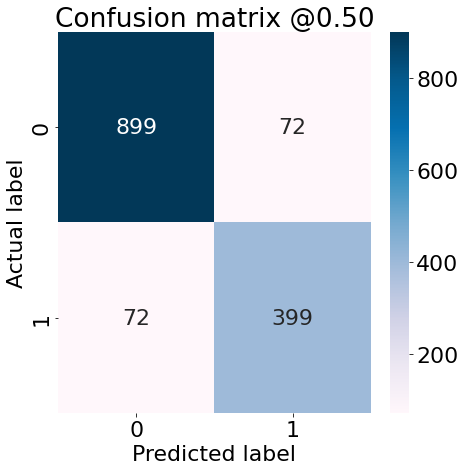

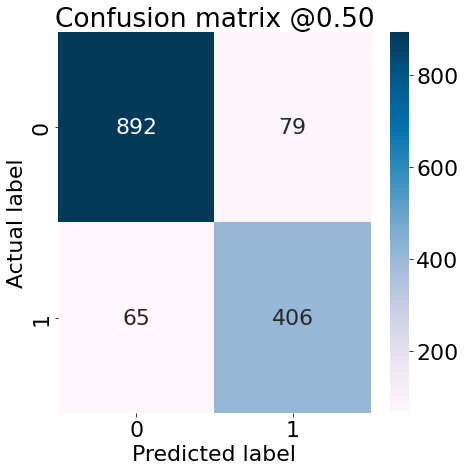

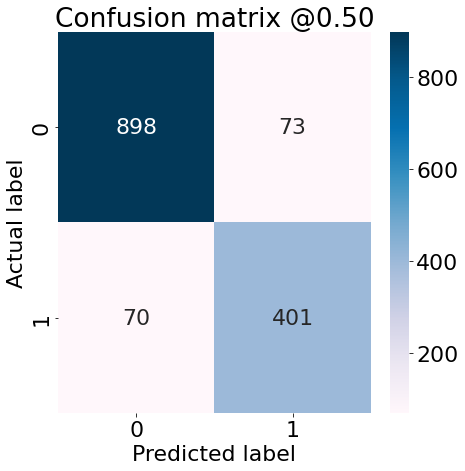

In [33]:
classifier = BertClassifier(
    path='cointegrated/rubert-tiny',
    n_classes=2
)

classifier.train(
        X_train=X_train,
        y_train=y_train,
        X_valid=X_val,
        y_valid=y_val,
        X_test=X_test,
        y_test=y_test,
        epochs=7
)

path = './trainer'
classifier.model.save_pretrained(path)
classifier.tokenizer.save_pretrained(path)